In [8]:
# !pip install pydicom pillow
!pip install ultralytics

In [9]:
import numpy as np
import pandas as pd
import os
import sys
import math
import random
import shutil

import cv2
import pydicom
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from ultralytics import YOLO

np.random.seed(42)

In [10]:
# shutil.rmtree('/kaggle/working/')

In [11]:
CSV_FILE = '../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
TRAIN_SRC_DIR = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/'
TEST_SRC_DIR = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images/'
DATASET_DIR = './dataset/'
TEST_IMG_DIR = 'test_images/'

os.mkdir(DATASET_DIR)
os.mkdir(DATASET_DIR + 'images/')
os.mkdir(DATASET_DIR + 'images/train/')
os.mkdir(DATASET_DIR + 'images/val/')
os.mkdir(DATASET_DIR + 'images/test/')
os.mkdir(DATASET_DIR + 'labels/')
os.mkdir(DATASET_DIR + 'labels/train/')
os.mkdir(DATASET_DIR + 'labels/val/')
os.mkdir(DATASET_DIR + 'labels/test/')
os.mkdir(TEST_IMG_DIR)

# Prepare images and labels for training

In [12]:
annotations = pd.read_csv(CSV_FILE)
print(annotations.info())
annotations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB
None


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [13]:
positive_annotations = annotations[annotations.Target == 1]
negative_annotations = annotations[annotations.Target == 0]

print(positive_annotations['patientId'].drop_duplicates().shape[0])
print(negative_annotations['patientId'].drop_duplicates().shape[0])
print(negative_annotations['patientId'].shape[0])

negative_sample = negative_annotations.sample(600)
negative_sample['patientId'].shape[0]

annotations = pd.concat([positive_annotations, negative_sample])
print(annotations.shape)
annotations.head()

6012
20672
20672
(10155, 6)


,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [14]:
patient_id_series = annotations.patientId.drop_duplicates()
print('Number of images:', patient_id_series.size)

train_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=42)
print('Train set number:', len(train_series))
print('Validation set number:', len(val_series))

Number of images: 6612
Train set number: 5950
Validation set number: 662


In [15]:
for patient_id in tqdm(train_series):
    src_path = TRAIN_SRC_DIR + patient_id + '.dcm'
    dcm_data = pydicom.dcmread(src_path)
    image_array = dcm_data.pixel_array
    image = Image.fromarray(image_array)
    image.save(DATASET_DIR + 'images/train/' + patient_id + '.jpg')
print('Images moved to train folder:', len(os.listdir(DATASET_DIR + 'images/train/')))
    
for patient_id in tqdm(val_series):
    src_path = TRAIN_SRC_DIR + patient_id + '.dcm'
    dcm_data = pydicom.dcmread(src_path)
    image_array = dcm_data.pixel_array
    image = Image.fromarray(image_array)
    image.save(DATASET_DIR + 'images/val/' + patient_id + '.jpg')
print('Images moved to val folder:', len(os.listdir(DATASET_DIR + 'images/val/')))

100%|██████████| 5950/5950 [01:34<00:00, 62.68it/s]


Images moved to train folder: 5950


100%|██████████| 662/662 [00:08<00:00, 81.33it/s]

Images moved to val folder: 662


In [16]:
def translate_bbox(bbox):
    img_size = 1024 # rsna defualt image size
    
    top_left_x = bbox[0]
    top_left_y = bbox[1]
    absolute_w = bbox[2]
    absolute_h = bbox[3]

    relative_w = absolute_w / img_size
    relative_h = absolute_h / img_size
    
    relative_x = top_left_x / img_size + relative_w / 2
    relative_y = top_left_y / img_size + relative_h / 2
    
    return relative_x, relative_y, relative_w, relative_h
    
def revert_bbox(rx, ry, rw, rh):
    img_size = 1024 # rsna defualt image size
    
    x = (rx-rw/2)*img_size
    y = (ry-rh/2)*img_size
    w = rw*img_size
    h = rh*img_size
    
    return x, y, w, h
    
    
def save_label(label_dir, patient_id, bbox):
    label_fp = os.path.join(label_dir, patient_id + '.txt')
    
    f = open(label_fp, "a")
    if (bbox == 'nan').all():
        f.close()
        return
    
    x, y, w, h = translate_bbox(bbox)
    
    line = f"0 {x} {y} {w} {h}\n"
    
    f.write(line)
    f.close()

In [19]:
LABELS_DIR = "./labels_temp/"
os.mkdir(LABELS_DIR)

for row in annotations.values:
    if pd.notna(row[1:5]).all():
        save_label(LABELS_DIR, row[0], row[1:5])
    
for patient_id in train_series:
    if os.path.isfile(LABELS_DIR + patient_id + '.txt'):
        shutil.copy(LABELS_DIR + patient_id + '.txt', DATASET_DIR + 'labels/train/')
    
for patient_id in val_series:
    if os.path.isfile(LABELS_DIR + patient_id + '.txt'):
        shutil.copy(LABELS_DIR + patient_id + '.txt', DATASET_DIR + 'labels/val/')
    
shutil.rmtree(LABELS_DIR)

# Display example from dataset

0 0.7412109375 0.49658203125 0.162109375 0.0966796875



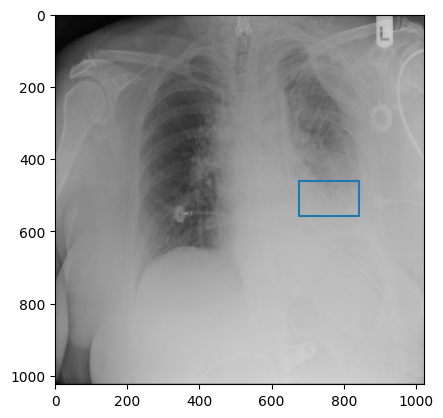

In [20]:
demo_patient_id = val_series.values[8]
demo_img_path = DATASET_DIR + 'images/val/' + demo_patient_id + '.jpg'
demo_label_path = DATASET_DIR + 'labels/val/' + demo_patient_id + '.txt'

plt.imshow(cv2.imread(demo_img_path))

with open(demo_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rx, ry, rw, rh = list(map(float, line.strip().split()))
        
        x, y, w, h = revert_bbox(rx, ry, rw, rh)
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

# Prepare configuration and run training

In [21]:
%%writefile config.yaml

path: '/kaggle/working/dataset' # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val  # val images (relative to 'path')

# Classes
names:
  0: pneumonia

Writing config.yaml


In [22]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 25.8MB/s]


In [23]:
results = model.train(data='config.yaml', epochs = 50)

Ultralytics YOLOv8.1.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=50, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 82.7MB/s]
2024-02-08 18:24:40,661	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-08 18:24:41,551	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-08 18:24:43.751437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 18:24:43.751561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 18:24:43.874780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 5405 images, 545 backgrounds, 0 corrupt: 100%|██████████| 5950/5950 [00:04<00:00, 1302.91it/s]


train: New cache created: /kaggle/working/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/dataset/labels/val... 607 images, 55 backgrounds, 0 corrupt: 100%|██████████| 662/662 [00:00<00:00, 1193.55it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.33G      1.996      2.713       1.95         49        640: 100%|██████████| 372/372 [01:21<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]

                   all        662        962      0.293       0.28      0.215     0.0719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.35G      1.989      2.279      1.885         31        640: 100%|██████████| 372/372 [01:12<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]


                   all        662        962      0.321      0.295      0.211     0.0605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.35G       1.99      2.174      1.876         35        640: 100%|██████████| 372/372 [01:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]


                   all        662        962      0.455      0.463      0.384      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.35G      1.957      2.102      1.856         25        640: 100%|██████████| 372/372 [01:10<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


                   all        662        962      0.429      0.447      0.383      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.35G      1.924      2.047      1.816         30        640: 100%|██████████| 372/372 [01:12<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        662        962      0.437       0.49      0.446      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.35G      1.922      2.015      1.808         28        640: 100%|██████████| 372/372 [01:11<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]

                   all        662        962      0.491      0.496      0.472      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.35G      1.901      1.975      1.775         28        640: 100%|██████████| 372/372 [01:12<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.58it/s]


                   all        662        962      0.564      0.476      0.488      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.35G      1.886      1.965       1.77         26        640: 100%|██████████| 372/372 [01:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


                   all        662        962      0.444      0.436      0.394      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.35G      1.868      1.953      1.757         36        640: 100%|██████████| 372/372 [01:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]

                   all        662        962       0.47      0.473      0.451      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.35G      1.854      1.924      1.747         26        640: 100%|██████████| 372/372 [01:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]

                   all        662        962      0.498      0.507       0.46      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.35G      1.848      1.926      1.737         40        640: 100%|██████████| 372/372 [01:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.76it/s]

                   all        662        962      0.432      0.387      0.366      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.35G      1.833      1.921      1.737         36        640: 100%|██████████| 372/372 [01:12<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]

                   all        662        962      0.484      0.475      0.439      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.35G      1.825      1.884      1.722         33        640: 100%|██████████| 372/372 [01:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


                   all        662        962      0.553      0.529      0.519      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.35G      1.831      1.903      1.731         26        640: 100%|██████████| 372/372 [01:12<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]

                   all        662        962      0.471      0.468      0.438      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.35G      1.833      1.897      1.731         27        640: 100%|██████████| 372/372 [01:12<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]

                   all        662        962      0.466      0.548      0.466      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.35G       1.82      1.875      1.715         40        640: 100%|██████████| 372/372 [01:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.77it/s]

                   all        662        962      0.496      0.534       0.48      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.35G      1.817      1.875      1.718         48        640: 100%|██████████| 372/372 [01:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.39it/s]

                   all        662        962       0.52      0.516      0.493      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.35G      1.801      1.872      1.701         36        640: 100%|██████████| 372/372 [01:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]

                   all        662        962      0.486       0.53       0.49      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.35G      1.793      1.853      1.697         22        640: 100%|██████████| 372/372 [01:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


                   all        662        962      0.495      0.538      0.486      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.35G      1.801      1.853      1.704         29        640: 100%|██████████| 372/372 [01:11<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


                   all        662        962      0.486      0.489      0.478      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.35G      1.787       1.84      1.703         27        640: 100%|██████████| 372/372 [01:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.77it/s]

                   all        662        962      0.507      0.556      0.503      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.35G      1.794      1.837      1.696         32        640: 100%|██████████| 372/372 [01:11<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.47it/s]

                   all        662        962      0.547      0.577      0.535      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.35G      1.781      1.834      1.693         39        640: 100%|██████████| 372/372 [01:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]

                   all        662        962      0.523      0.534      0.517       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.35G      1.778       1.83       1.68         32        640: 100%|██████████| 372/372 [01:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.69it/s]

                   all        662        962       0.51      0.512      0.488      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.35G      1.779      1.806      1.688         41        640: 100%|██████████| 372/372 [01:13<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]

                   all        662        962      0.503      0.555       0.51      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.35G      1.771      1.792      1.685         36        640: 100%|██████████| 372/372 [01:13<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.71it/s]

                   all        662        962      0.519      0.551       0.52       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.35G      1.765      1.809      1.692         33        640: 100%|██████████| 372/372 [01:13<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.73it/s]

                   all        662        962      0.513      0.529      0.515       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.35G      1.755      1.804      1.677         40        640: 100%|██████████| 372/372 [01:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.80it/s]

                   all        662        962      0.506       0.54        0.5      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.35G      1.757       1.79      1.669         35        640: 100%|██████████| 372/372 [01:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]


                   all        662        962      0.512      0.572       0.53      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.35G      1.755      1.771      1.666         31        640: 100%|██████████| 372/372 [01:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.80it/s]

                   all        662        962      0.514      0.537      0.499      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.35G      1.752      1.779      1.663         37        640: 100%|██████████| 372/372 [01:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]

                   all        662        962      0.535      0.585      0.534       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.35G      1.735      1.749      1.653         29        640: 100%|██████████| 372/372 [01:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


                   all        662        962      0.519       0.58      0.518      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.35G      1.741      1.745      1.657         39        640: 100%|██████████| 372/372 [01:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.79it/s]

                   all        662        962      0.551      0.568      0.532      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.35G      1.737       1.75       1.66         32        640: 100%|██████████| 372/372 [01:12<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.31it/s]

                   all        662        962      0.537      0.577      0.528      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.35G      1.725       1.74      1.642         45        640: 100%|██████████| 372/372 [01:13<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


                   all        662        962      0.531      0.541      0.514      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.35G      1.727       1.75      1.648         43        640: 100%|██████████| 372/372 [01:13<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


                   all        662        962      0.523      0.571      0.528       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.35G      1.718      1.714      1.634         32        640: 100%|██████████| 372/372 [01:13<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


                   all        662        962      0.526      0.571      0.536      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.35G       1.72      1.725      1.641         27        640: 100%|██████████| 372/372 [01:12<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.79it/s]

                   all        662        962      0.462      0.595      0.509      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.35G      1.711      1.719      1.646         33        640: 100%|██████████| 372/372 [01:12<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.60it/s]


                   all        662        962      0.525      0.599      0.548      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.35G      1.697      1.696      1.627         38        640: 100%|██████████| 372/372 [01:13<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.60it/s]


                   all        662        962       0.49      0.576       0.52      0.217
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.35G      1.793      1.668       1.75         21        640: 100%|██████████| 372/372 [01:14<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.57it/s]


                   all        662        962      0.523      0.584      0.535      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.35G      1.787      1.633      1.737         22        640: 100%|██████████| 372/372 [01:12<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.64it/s]


                   all        662        962      0.521      0.597      0.549      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.35G      1.771      1.638      1.729         26        640: 100%|██████████| 372/372 [01:12<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.23it/s]

                   all        662        962      0.544      0.569      0.523       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.35G      1.761      1.618      1.721         25        640: 100%|██████████| 372/372 [01:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]

                   all        662        962      0.503       0.58      0.522      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.35G      1.753      1.625      1.726         22        640: 100%|██████████| 372/372 [01:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.71it/s]

                   all        662        962      0.509      0.621      0.534      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.35G      1.748      1.604      1.722         25        640: 100%|██████████| 372/372 [01:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]

                   all        662        962      0.492      0.602      0.514       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.35G      1.736        1.6      1.722         18        640: 100%|██████████| 372/372 [01:13<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.56it/s]


                   all        662        962      0.514      0.597      0.534      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.35G      1.728      1.588      1.718         17        640: 100%|██████████| 372/372 [01:12<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]


                   all        662        962      0.516      0.613      0.534      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.35G      1.734      1.567      1.716         19        640: 100%|██████████| 372/372 [01:11<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.58it/s]


                   all        662        962      0.505      0.629      0.537      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.35G      1.719      1.573      1.706         20        640: 100%|██████████| 372/372 [01:12<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.61it/s]


                   all        662        962      0.514      0.609      0.545       0.23

50 epochs completed in 1.085 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.01it/s]


                   all        662        962      0.511      0.606      0.544      0.229
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▁▅▅▆▇▅▆▄▆▇▆▇▇▇▇▇█▇▇▇▇▇██▇████▇███▇▇▇███
metrics/mAP50-95(B),▁▁▄▄▆▆▅▆▅▅▇▅▆▇▇▇▇█▇▇▇▇▇▇█▇▇▇█▇▇█████████
metrics/precision(B),▁▂▅▅▆█▅▆▅▆█▆▆▇▆▆▇█▇▇▇▇▇▇▇▇█▇▇▇▅▇▇▇▇▆▆▇▇▇
metrics/recall(B),▁▁▅▅▆▅▄▅▃▅▆▅▆▆▆▆▇▇▆▆▇▆▆▇▇▇▇▇▇▇██▇█▇▇████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,███▇▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▃▃▂▂▂▂▁▁


# Inspect model predictions

In [24]:
def plot_val_pred(demo_patient_id, verbose=True, split='val'):
    demo_img_path = DATASET_DIR + f'images/{split}/' + demo_patient_id + '.jpg'
    demo_label_path = DATASET_DIR + f'labels/{split}/' + demo_patient_id + '.txt'

    res = model(demo_img_path, verbose=verbose)
    if verbose:
        print(res[0].probs)
        print(res[0].boxes.xywh)

    plt.imshow(cv2.imread(demo_img_path))

    img_size = 1014
    with open(demo_label_path, "r") as f:
        for line in f:
            if verbose:
                print(line)
            class_id, rx, ry, rw, rh = list(map(float, line.strip().split()))

            x, y, w, h = revert_bbox(rx, ry, rw, rh)
            plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y], c='blue')

    for box in res[0].boxes.xywh.cpu():
        px, py, pw, ph = box
        plt.plot([px-pw/2, px-pw/2, px+pw/2, px+pw/2, px-pw/2], [py-ph/2, py+ph/2, py+ph/2, py-ph/2, py-ph/2], c='orange')

<Figure size 640x480 with 0 Axes>

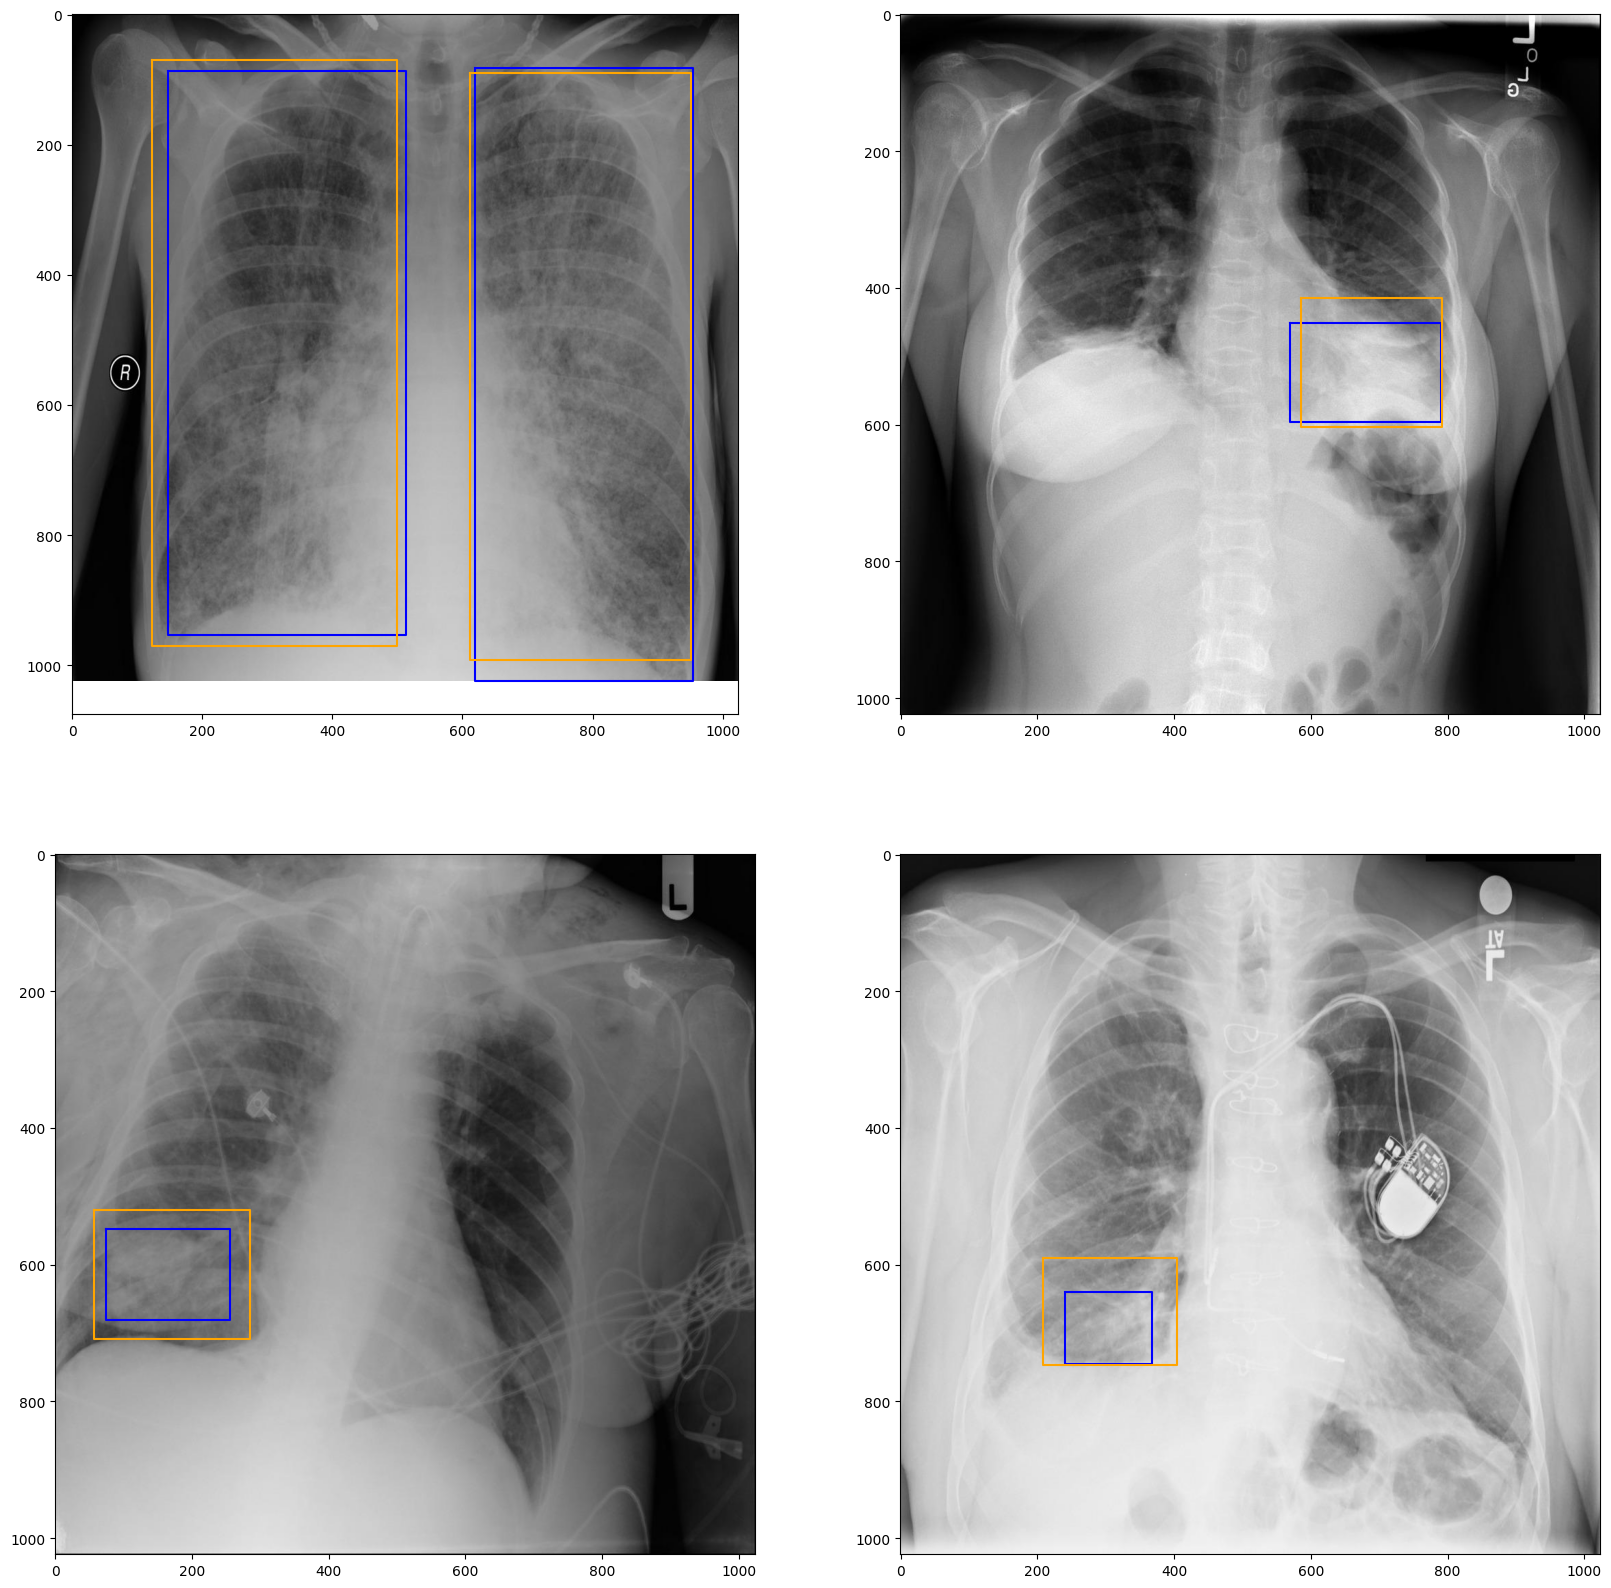

In [27]:
def random_value(series):
    return series.iloc[random.randrange(0, len(series))]

def plot_examples(series, rows = 5, cols = 2, split='val'):
    plt.suptitle(split)
    plt.figure(figsize=(10*cols,10*rows))
    # plot_val_pred(random_value(val_series), verbose=False)
    for h in range(rows):
        for w in range(cols):
            plt.subplot(rows, cols, h*2+w+1)
            plot_val_pred(random_value(series), verbose=False, split=split)

plot_examples(train_series, 2, 2, 'train')

<Figure size 640x480 with 0 Axes>

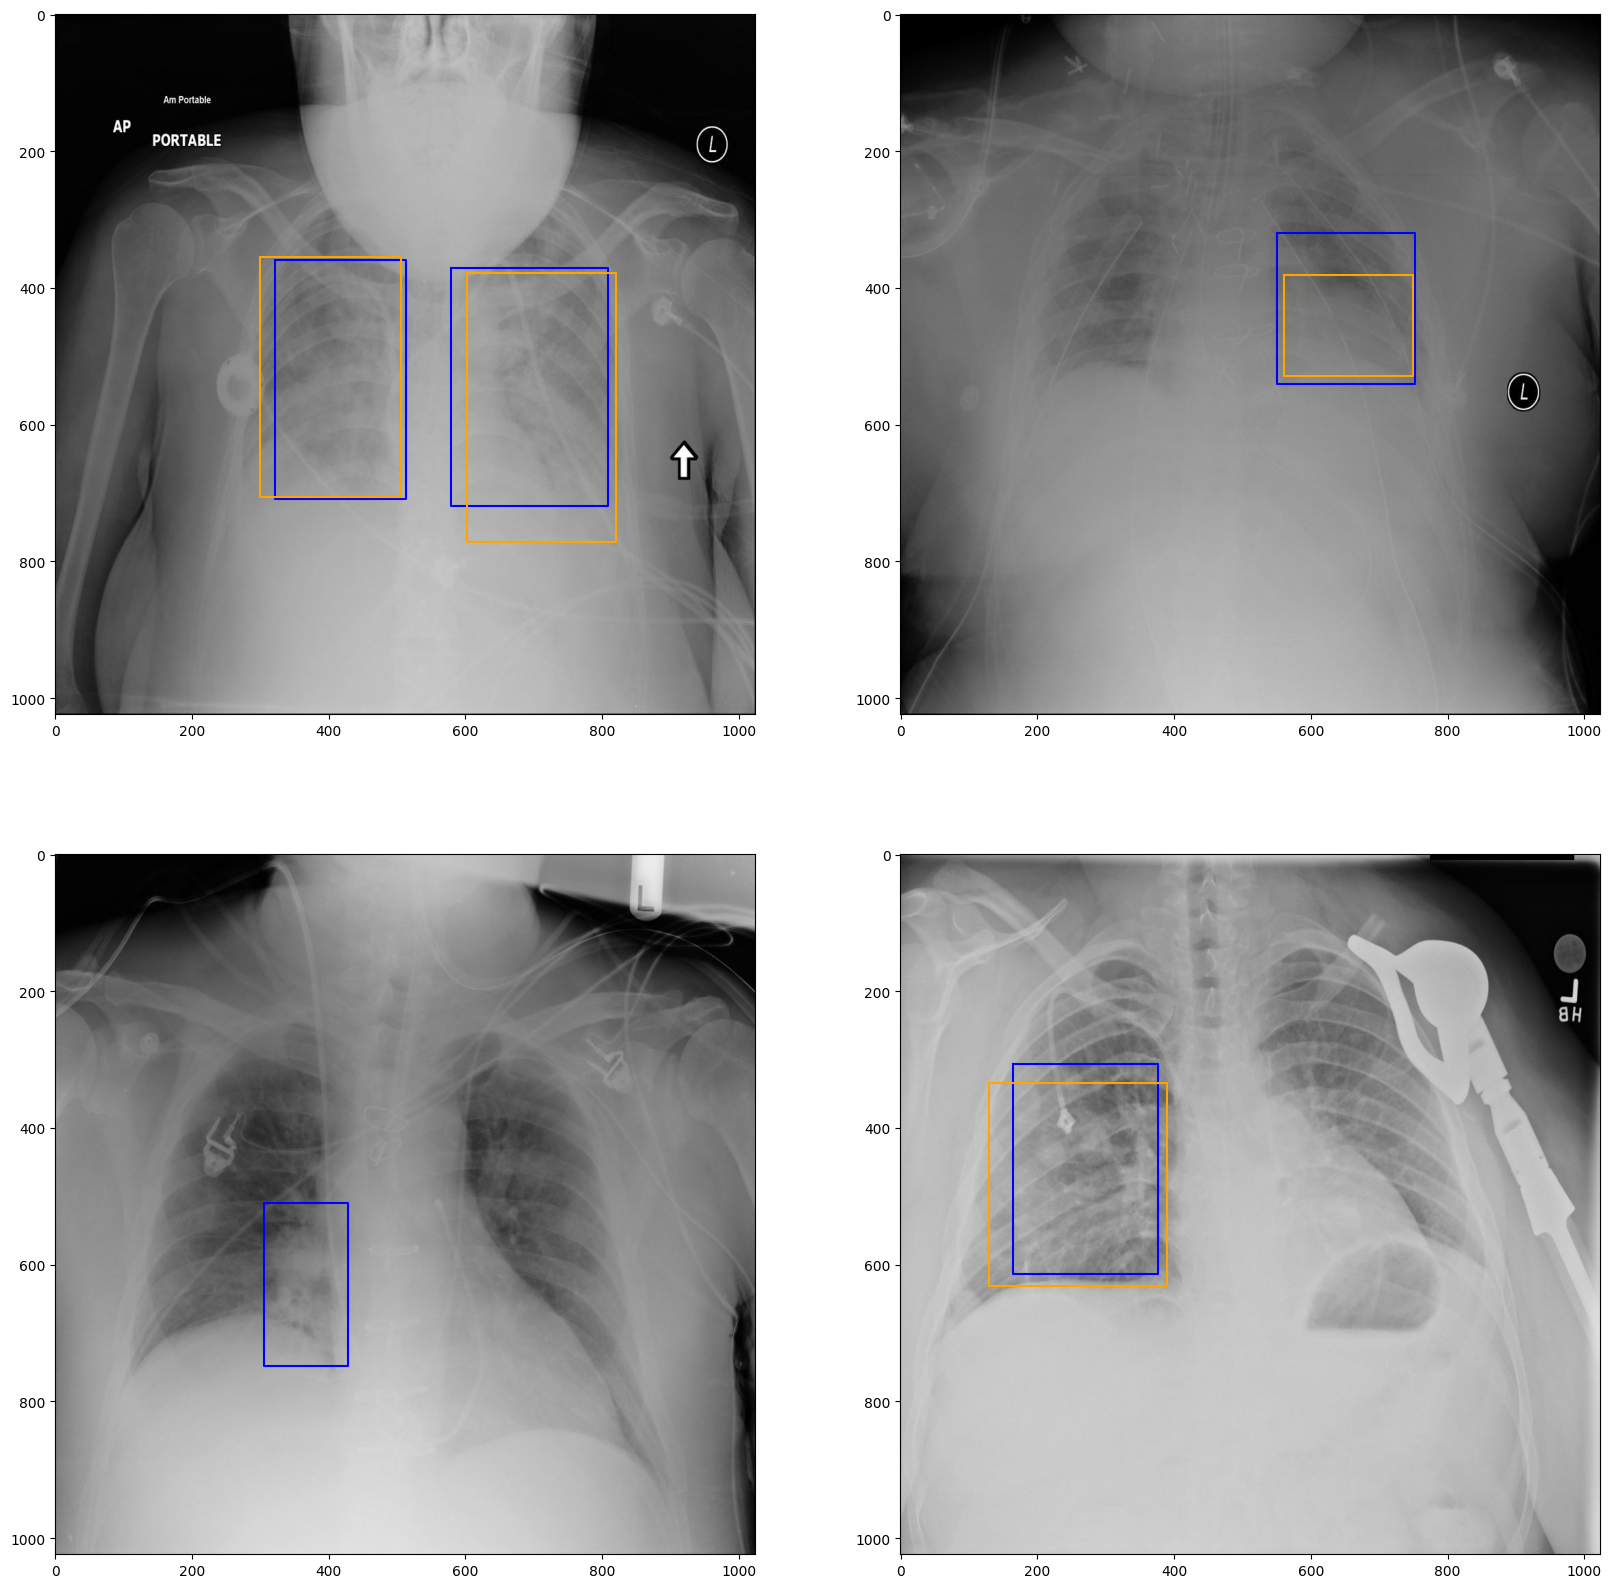

In [28]:
plot_examples(val_series, 2, 2, 'val')

# Prepare test dataset

In [29]:
for file in tqdm(os.listdir(TEST_SRC_DIR)):
    src_path = TEST_SRC_DIR + file
    dcm_data = pydicom.dcmread(src_path)
    image_array = dcm_data.pixel_array
    image = Image.fromarray(image_array)
    image.save(TEST_IMG_DIR + os.path.splitext(file)[0] + '.jpg')

100%|██████████| 3000/3000 [00:44<00:00, 67.76it/s]


# Generate submission.csv

In [30]:
results = model(TEST_IMG_DIR, verbose=False)


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



In [31]:
def get_id_from_path(path):
    return os.path.splitext(os.path.basename(path))[0]

print(get_id_from_path(results[1].path))
print(results[1].boxes.xywh)
print(results[1].boxes.conf)

0005d3cc-3c3f-40b9-93c3-46231c3eb813
tensor([[383.9973, 287.2116, 118.8094, 178.9754]], device='cuda:0')
tensor([0.3058], device='cuda:0')


In [32]:
with open('submission.csv', 'w') as file:
    file.write("patientId,PredictionString\n")

    for result in tqdm(results):
        line = get_id_from_path(result.path) + ','
        
        for conf, xywh in zip(result.boxes.conf, result.boxes.xywh):
            x, y, w, h = xywh
            line += f"{conf:.2f} {x:.2f} {y:.2f} {w:.2f} {h:.2f} "
            
        line = line.strip()
        file.write(line+"\n")

100%|██████████| 3000/3000 [00:00<00:00, 4528.69it/s]


In [33]:
shutil.make_archive('runs_archive', 'zip', 'runs')

'/kaggle/working/runs_archive.zip'